# 8PSK
Con 8PSK los bits entrantes se codifican en grupos de 3 llamados tribits $2^3 = 8$, lo cual produce 8 distintas combinaciones de entrada: 000, 001, 010, 011, 100, 101, 111 y produce 8 distintas fases de salida: (±22,5°, ±67.5°, ±112.5°, ±157.5).

In [58]:
# librerías a usar
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [59]:
#Reference: https://www.gaussianwaves.com/2015/06/how-to-generate-awgn-noise-in-matlaboctave-without-using-in-built-awgn-function/
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal 's' to generate a resulting signal vector 'r' of specified 
    SNR in dB. It also returns the noise vector 'n' that is added to the signal 's' and the power spectral density N0 of noise added
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB) for the received signal
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal
    return r, n

### Relación entre bits, samples y símbolos:

<p align="center">

$\frac{samples}{second} \times \frac{symbols}{sample} \times \frac{bits}{symbol} = \frac{bits}{second}$
</p>

- Sample: es el resultado de muestrear una señal continua en el tiempo obteniendo una representación discreta de la misma. El teorema de Nyquist-Shannon nos dice que la frecuencia de muestreo debe ser de, al menos, el doble de la frecuencia de la señal muestreada para que dicha señal pueda ser reconstruida. 
- Simbolo: es una forma de onda, un estado o una condición del canal de comunicación que persiste en un periodo fijo de tiempo. Un transmisor envía simbolos a una tasa conocida, y el receptor tiene el trabajo de detectar la secuencia de símbolos con el objetivo de reconstruir la información.

In [60]:
#---------------- Parámetros de la simulación ----------------
sample_rate = 100 #[Hz] samples per second
sampling_period = 1/sample_rate  # [s] time between samples
sps = 8  # [samples/symbol] cantidad de samples por simbolo
N = 600  # [bits] cantidad de bits a transmitir
Nsym = int(N/sps)  # [symbols] cantidad de simbolos que tomamos en total
symbol_period = sampling_period*sps  # [s] periodo de cada simbolo

print("Cantidad de samples: ", N, "\nCantidad de simbolos: ", Nsym)

Cantidad de samples:  600 
Cantidad de simbolos:  75


# Transmisor
El transmisor consiste en lo siguiente:
<div align="center"><b> 

![diagramatx_8psk](https://github.com/sofia-am/digital_communications/blob/master/img/diagramabloques_tx8psk_50.png?raw=true)
</b></div>

Es de interés hacer incapié en el convertidor de 2 a 4 niveles ya que es clave para hacer que la relación entre las distintas fases de los componentes de la señal compleja que se utiliza nos den como resultado una separación de 45° en el diagrama de constelación.

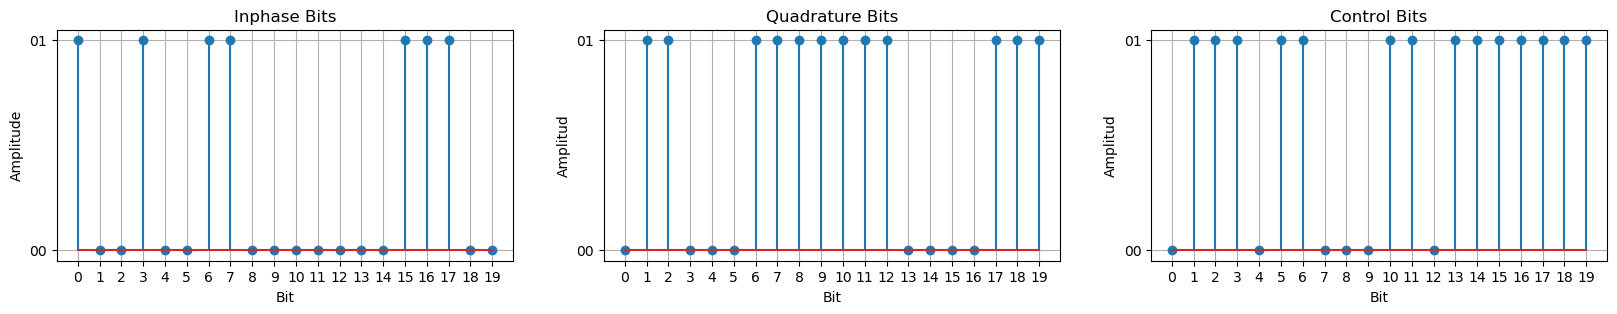

In [61]:
#----------- Datos de Entrada: Q I C ----------------
from matplotlib.ticker import StrMethodFormatter

bits = np.random.randint(0, 2, N)  # [0,1] bits aleatorios

i_bits = bits[0::3]  # bits inphase
q_bits = bits[1::3]  # bits quadrature
c_bits = bits[2::3]  # bits de control

fig = plt.figure(figsize=(20, 3))
ax_i = plt.subplot(1,3,1)
ax_i.yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
ax_i.yaxis.set_ticks(np.arange(0, 11, 1))
ax_i.xaxis.set_ticks(np.arange(0, len(i_bits), 1))
ax_i.set_title("Inphase Bits")
ax_i.grid(True)
ax_i.set_xlabel("Bit")
ax_i.set_ylabel("Amplitude")
ax_i.stem(i_bits[0:20], use_line_collection=True)

ax_q = plt.subplot(1,3,2)
ax_q.yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
ax_q.yaxis.set_ticks(np.arange(0, 11, 1))
ax_q.xaxis.set_ticks(np.arange(0, len(q_bits), 1))
ax_q.set_title("Quadrature Bits")
ax_q.set_xlabel("Bit")
ax_q.set_ylabel("Amplitud")
ax_q.stem(q_bits[0:20], use_line_collection=True)
ax_q.grid(True)

#plt.figure(figsize=(20, 3))
ax_c = plt.subplot(1,3,3)
ax_c.yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
ax_c.yaxis.set_ticks(np.arange(0, 11, 1))
ax_c.xaxis.set_ticks(np.arange(0, len(c_bits), 1))
ax_c.set_title("Control Bits")
ax_c.set_xlabel("Bit")
ax_c.set_ylabel("Amplitud")
ax_c.stem(c_bits[0:20], use_line_collection=True)
ax_c.grid(True)
plt.show()

El el siguiente bloque se realiza un oversampling y se establecen los niveles de tensión de acuerdo a las distintas combinaciones de bits de entrada:
<div align="center">

![voltage](https://github.com/sofia-am/digital_communications/blob/master/img/voltagevalues.jpg?raw=true)
</div>

- I, Q determinan la polaridad: 
    - '0' binario = '-' (signo negativo)
    - '1' binario = '+' (signo positivo)
- C, |C determinan el nivel de voltaje: 
    - '1' binario = 1.307 volts
    - '0' binario = 0.541 volts.

Entonces: 2 niveles + 2 polaridades nos da 4 condiciones en cada canal (I & Q) 

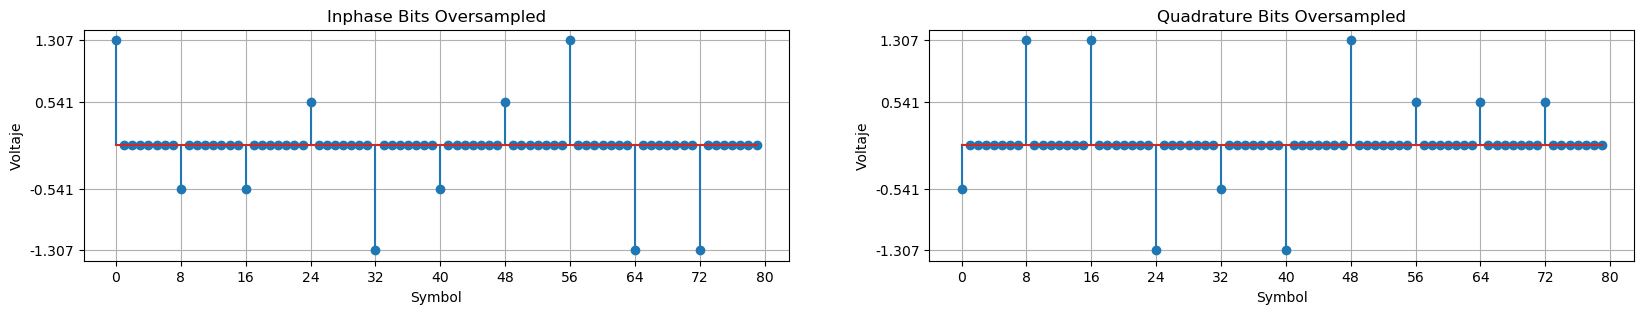

In [62]:
#------------- Tablas de Verdad ----------------
voltage_qc = {}
voltage_qc[(0,0)] = -0.541
voltage_qc[(0,1)] = -1.307
voltage_qc[(1,0)] = 0.541
voltage_qc[(1,1)] = 1.307

voltage_ic = {}
voltage_ic[(0,0)] = -1.307
voltage_ic[(0,1)] = -0.541
voltage_ic[(1,0)] = 1.307
voltage_ic[(1,1)] = 0.541

i_PAM = np.array([])
for index, bit in enumerate(c_bits):
    #print("bits: ", i_bits[index], c_bits[index])
    #print("voltage_ic: ", voltage_ic[(i_bits[index], c_bits[index])])
    pulse = np.zeros(sps)  # "relleno" un array de 8 bits con 0
    pulse[0] = voltage_ic[(i_bits[index], c_bits[index])]  # asigno el valor de la señal
    # concateno el array de 8 bits con el array de bits
    i_PAM = np.concatenate((i_PAM, pulse))

q_PAM = np.array([])
for index, bit in enumerate(q_bits):
    pulse = np.zeros(sps)  # "relleno" un array de 8 bits con 0
    pulse[0] = voltage_qc[(q_bits[index], c_bits[index])]  # asigno el valor de la señal
    # concateno el array de 8 bits con el array de bits
    q_PAM = np.concatenate((q_PAM, pulse))

fig, (ax_i, ax_q) = plt.subplots(1, 2, figsize=(20, 3))
ax_i.yaxis.set_major_formatter(StrMethodFormatter("{x:.03f}"))
ax_i.yaxis.set_ticks([-1.307, -0.541, 0.541, 1.307])
ax_i.xaxis.set_ticks(np.arange(0, len(i_PAM), 8))
ax_i.set_title("Inphase Bits Oversampled")
ax_i.grid(True)
ax_i.set_xlabel("Symbol")
ax_i.set_ylabel("Voltaje")
ax_i.stem(i_PAM[0:80], use_line_collection=True)

ax_q.yaxis.set_major_formatter(StrMethodFormatter("{x:.03f}"))
ax_q.yaxis.set_ticks([-1.307, -0.541, 0.541, 1.307])
ax_q.xaxis.set_ticks(np.arange(0, len(i_PAM), 8))
ax_q.set_title("Quadrature Bits Oversampled")
ax_q.set_xlabel("Symbol")
ax_q.set_ylabel("Voltaje")
ax_q.stem(q_PAM[0:80], use_line_collection=True)
ax_q.grid(True)
plt.show()

# Root Raised-Cosine Filter
![rrcfilter](https://github.com/sofia-am/digital_communications/blob/master/img/raised-cosine-pulse.png?raw=true) 

Es un filtro pasa bajo muy utilizado para limitar el ancho de banda que nuestra señal va a ocupar. También tiene la propiedad de valer 0 en intervalos de T. El filtrado se realiza parcialmente en el transmisor, para limitar el ancho de banda, y parcialmente en el receptor, para limitar la interferencia. 

La **raiz cuadrada** del filtro proviene del dominio de la frecuencia, de esta manera tomamos la raiz cuadrada de la respuesta en frecuencia del filtro coseno realzado para obtener el filtro *parcial* que necesitamos. 

### Factor de Roll-Off
El parámetro $\beta$ toma valores entre 0 y 1 y determina cuán rapido, en el dominio del tiempo, el filtro decae a 0. Mientras más bajo sea el roll-off, más compacta es nuestra señal en frecuencia.

### Parámetros

La función `rrcosfilter` toma como parámetros:

- `N`: span o tamaño del filtro en samples
- `alpha`: factor de roll-off entre [0,1]
- `Ts`: periodo de muestreo en segundos
- `Fs`: frecuencia de muestreo en Hz

En la siguiente imagen se pueden observar los diferentes comportamientos del filtro de acuerdo al cambio de algunos de estos parámetros

![filterresponse](https://github.com/sofia-am/digital_communications/blob/master/img/srrcDesign_impulseResponse-1.png?raw=true)



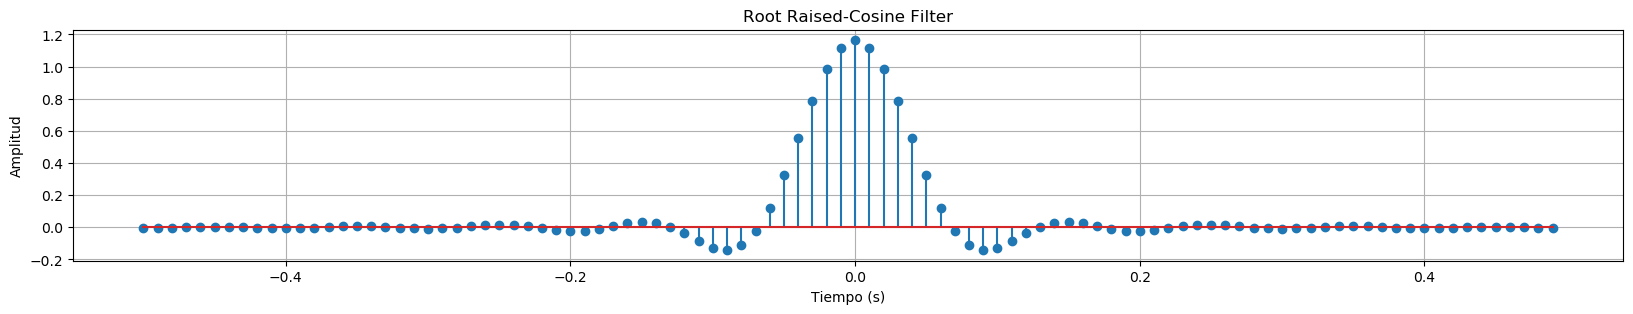

In [63]:
from commpy.filters import rrcosfilter

length = 100
beta = 0.6
Tsym = sps*sampling_period

time, filter_response = rrcosfilter(length, beta, Tsym, sample_rate)
# time:  Array containing the time indices, in seconds, for the impulse response.
# filter_response:  Array containing the impulse response values.

plt.figure(figsize=(20, 3))
plt.stem(time, filter_response, use_line_collection=True)
plt.title("Root Raised-Cosine Filter")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

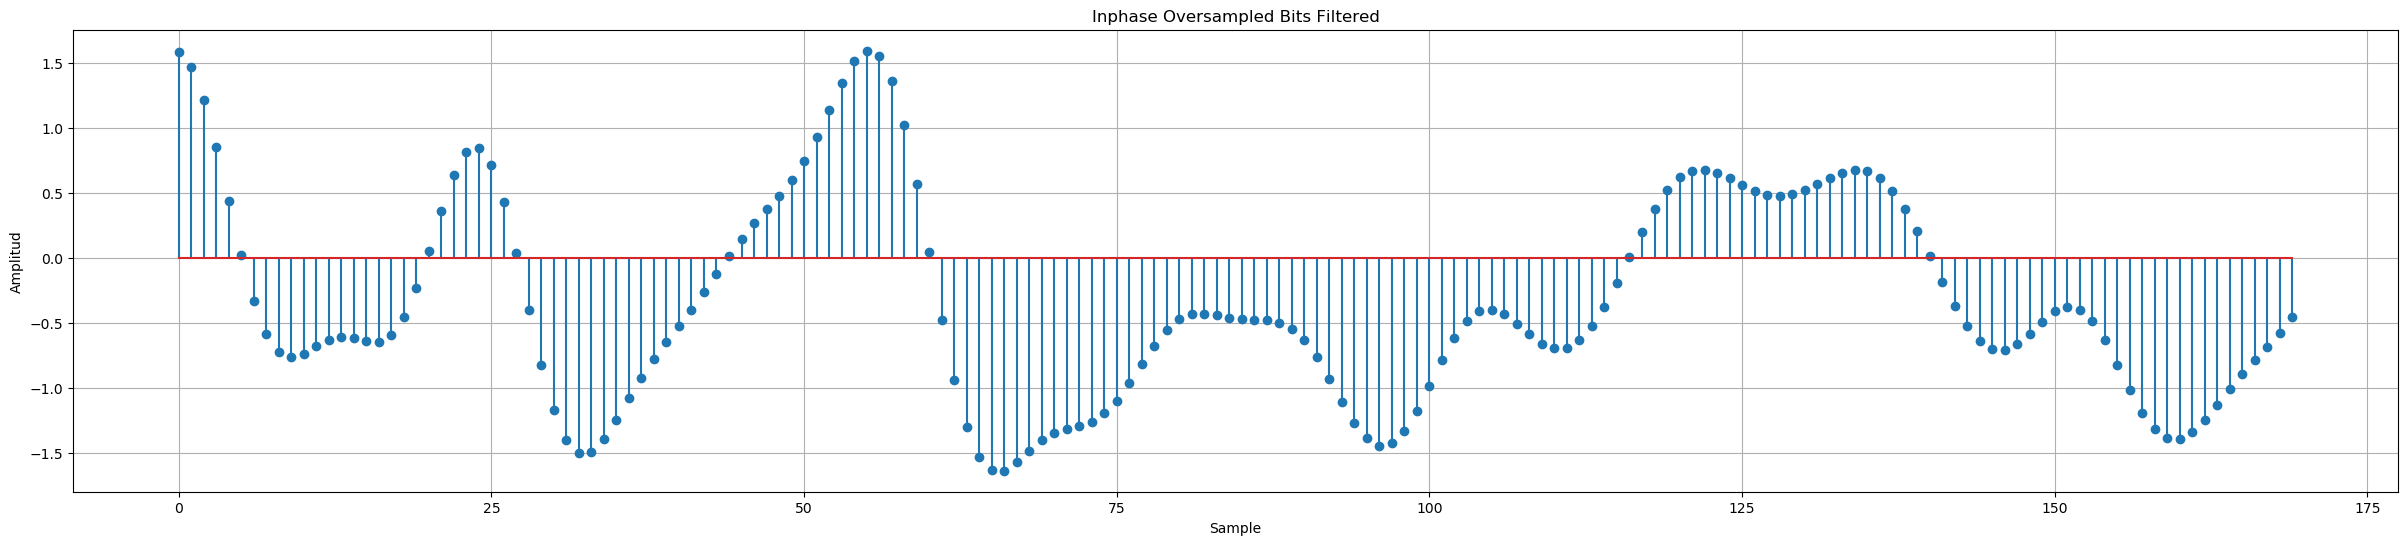

In [64]:
i_filtered = np.convolve(i_PAM, filter_response)
delay = int(length/2)
i_filtered = i_filtered[delay:]  # elimino el comportamiento transitorio

fig, ax = plt.subplots(figsize=(30, 6))
#ax.yaxis.set_major_formatter(StrMethodFormatter("{x:02f}"))
#ax.yaxis.set_ticks(np.arange(i_filtered.min, i_filtered.max))
ax.set_title("Inphase Oversampled Bits Filtered")
ax.grid(True)
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitud")
ax.stem(i_filtered[0:170], use_line_collection=True)
plt.show()

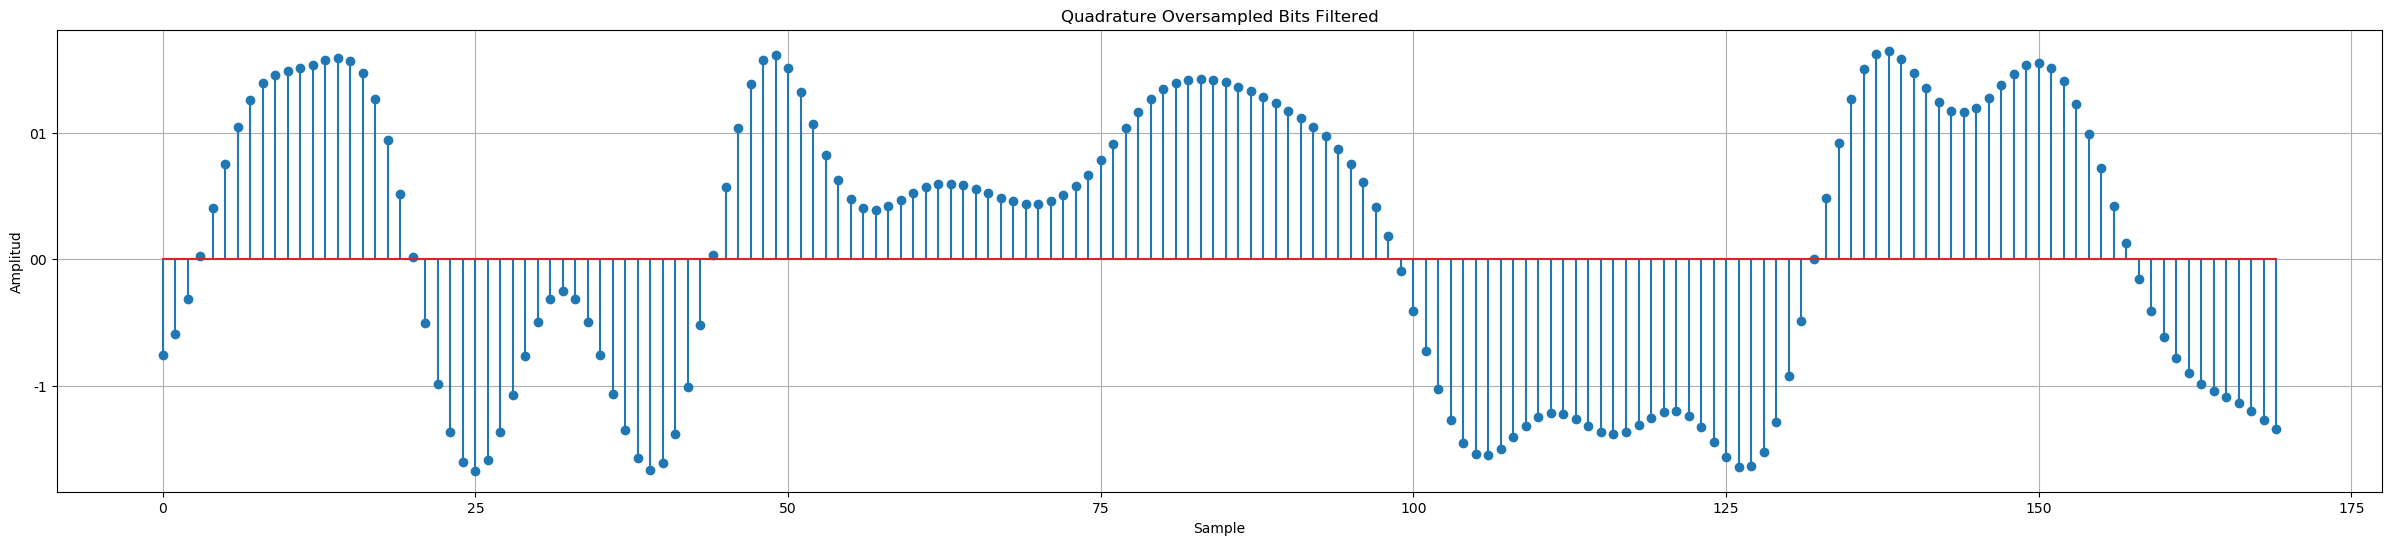

In [65]:
q_filtered = np.convolve(q_PAM, filter_response)
q_filtered = q_filtered[delay:]

fig, ax = plt.subplots(figsize=(30, 6))
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:02b}"))
ax.yaxis.set_ticks(np.arange(-11, 11, 1))
ax.set_title("Quadrature Oversampled Bits Filtered")
ax.grid(True)
ax.set_xlabel("Sample")
ax.set_ylabel("Amplitud")
ax.stem(q_filtered[0:170], use_line_collection=True)
plt.show()

# Modulación 

En el siguiente bloque se generan las dos señales portadoras. Son ortogonales entre sí ya que se encuentran defasadas 90°.
Las ondas portadoras son representadas con las siguientes funciones:

$\phi_1(t) = \sqrt{\frac{2}{T_s}} cos(2\pi f_c t)$

$\phi_2(t) = \sqrt{\frac{2}{T_s}} sen(2\pi f_c t)$

donde $T_s$ es el periodo de símbolo y $f_c$ la frecuencia de la portadora.

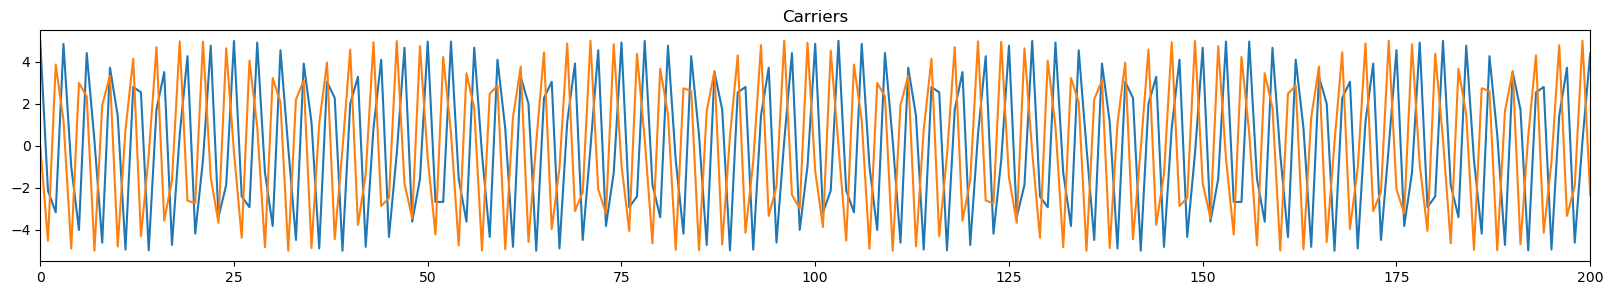

In [121]:
Fc = 1e5  # [Hz] carrier frequency
#t = np.arange(0, 2*np.pi, 2*np.pi/len(i_filtered))
t = np.linspace(0, 1, len(i_filtered))
#print("i_filtered size: ", len(i_filtered), "\nt size: ", len(t))

i_carrier = np.sqrt(2/symbol_period)*np.cos((2.0*np.pi*Fc*t))
q_carrier = np.sqrt(2/symbol_period)*np.sin((2.0*np.pi*Fc*t))

plt.figure(figsize=(20, 3))
plt.plot(i_carrier)
plt.plot(q_carrier)
plt.xlim(0, 200)
plt.title("Carriers")
plt.show()

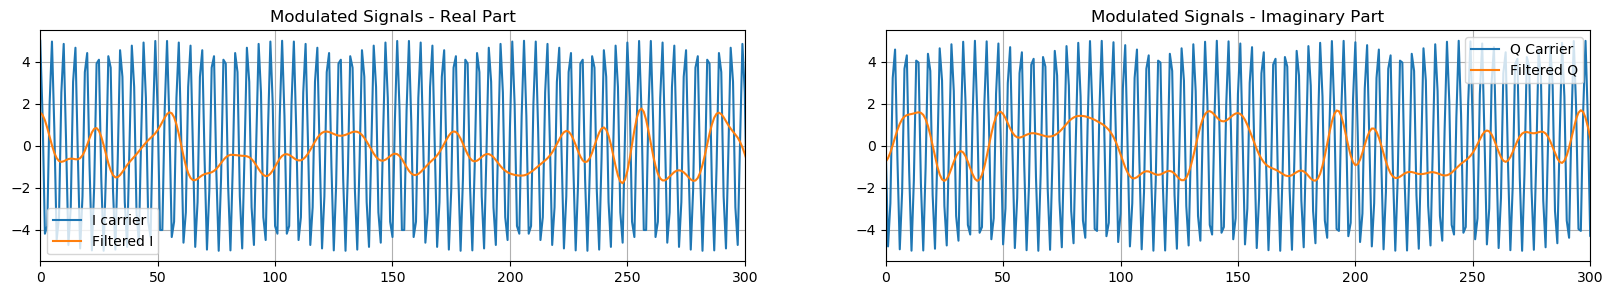

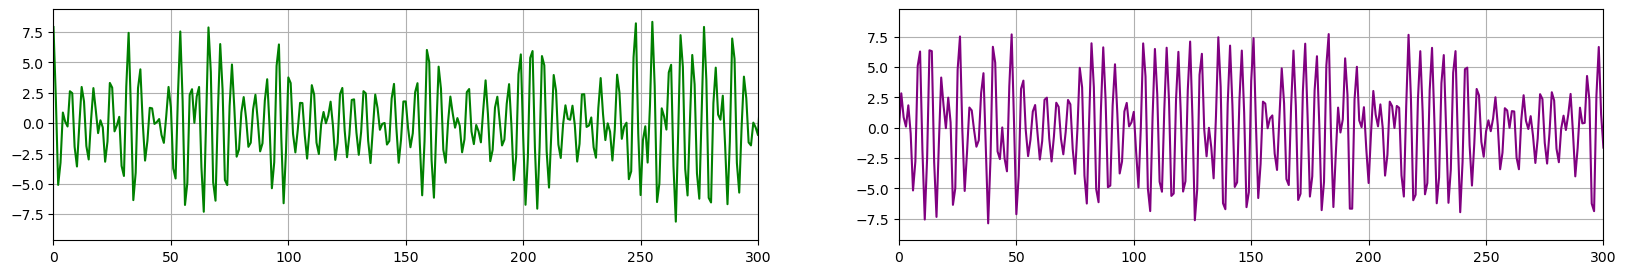

In [114]:
q_modulated = q_filtered * q_carrier
i_modulated = i_filtered * i_carrier

#print("q_filtered size:", len(q_filtered), "q_carrier size:", len(q_carrier))
#print("\n t size:", len(t))

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(i_carrier, label="I carrier")
plt.plot(i_filtered, label="Filtered I")
plt.xlim(0, 300)
plt.title("Modulated Signals - Real Part")
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(q_carrier, label="Q Carrier")
plt.plot(q_filtered, label="Filtered Q")
plt.xlim(0, 300)
plt.title("Modulated Signals - Imaginary Part")
plt.grid(True)
plt.legend()
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(i_modulated,color="green", label="Modulated I")
plt.xlim(0, 300)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(q_modulated, color="purple", label="Modulated Q")
plt.xlim(0, 300)
plt.grid(True)
plt.show()


# Ruido aditivo blanco Gaussiano
Es el modelo básico de ruido que se utiliza en comunicaciones para modelar el efecto de muchos procesos aleatorios que ocurren en la naturaleza.

- Aditivo: porque se agrega a cualquier ruido que pueda ser intrínseco al sistema.
- Blanco: se refiere a la idea de que tiene una potencia uniforme a lo largo de la banda de frecuencia del sistema de información. Es una analogía al color blanco el cual tiene emisiones uniformes a todas las frecuencias en el espectro visible.
- Gaussiano: porque tiene una distribución normal en el dominio del tiempo con una media de cero.

El canal AWGN está representado por una serie de salidas $Y_i$ cuyo evento de tiempo discreto es de índice $i$. $Y_i$ es la suma de todas las entradas $X_i$ y ruido $Z_i$, el cual es intependiente y distribuido de manera idéntica, y es tomado de una distribucion normal con media 0 y varianza N(el ruido). Se asume que los valores $Z_i$ no tienen correlación con los $X_i$.

$Z_i \sim \mathcal{N}(0, N)$

$Y_i = X_i + Z_i$

### Parámetros

La función `awgn` toma como parámetros:

- `s`: el vector con la señal.
- `SNRdB`: relación señal/ruido deseada (expresada en dB) para la señal recibida.
- `L`: oversampling factor, por default en 1.

Dicha función retorna: un vector con los valores de la señal con ruido, y otro vector con el ruido (que se imprime en pantalla para observar mejor cómo cambia la señal respecto al ruido)

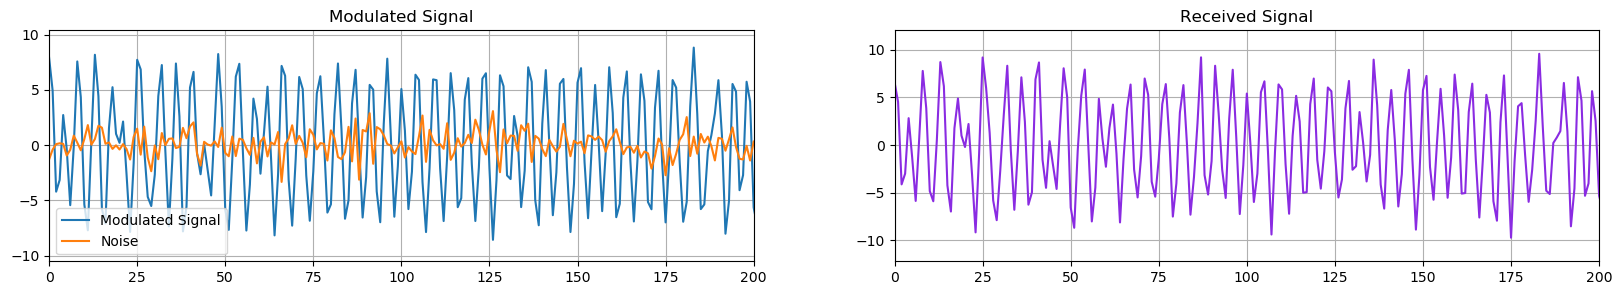

In [115]:
signal_modulated = i_modulated + q_modulated
#noise = np.random.randn(len(signal_modulated))
#noise = np.random.normal(0, 0.4, len(signal_modulated))
#signal_noise = signal_modulated + noise
SNRdb = 10 # [dB] A ratio higher than 1:1 (greater than 0 dB) indicates more signal than noise. 
signal_noise, noise = awgn(signal_modulated, SNRdb, 1)
t = np.arange(len(signal_modulated))

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(signal_modulated, label="Modulated Signal")
plt.plot(noise, label="Noise")
plt.xlim(0, 200)
plt.title("Modulated Signal")
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(signal_noise, "blueviolet", label="Modulated Signal + Noise")
plt.xlim(0, 200)
plt.title("Received Signal")
plt.grid(True)
plt.show()


# Receptor

Se recuperan las componentes I & Q de la señal:

![rx8bpsk](https://github.com/sofia-am/digital_communications/blob/master/img/diagramabloques_rx8psk_50.png?raw=true)

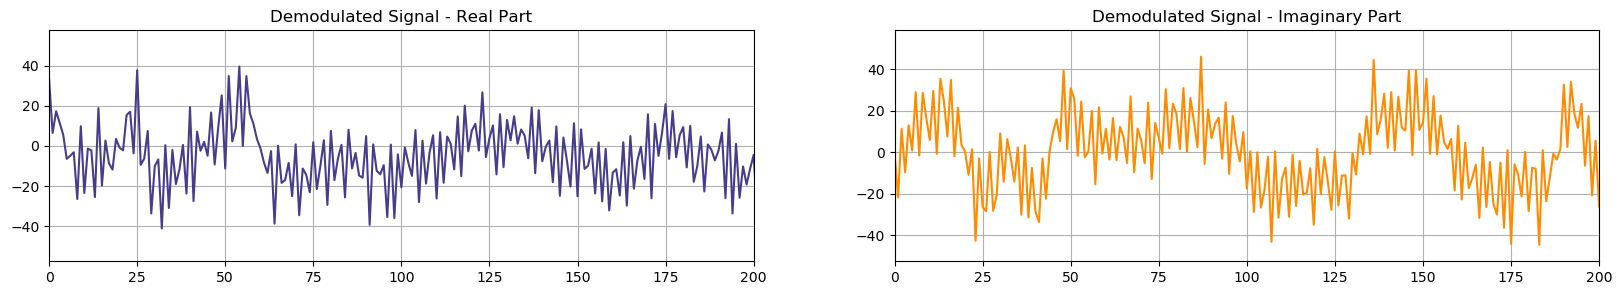

In [116]:
demodulated_i = signal_noise * i_carrier
demodulated_q = signal_noise * q_carrier

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(demodulated_i, "darkslateblue")
plt.xlim(0, 200)
plt.grid(True)
#plt.ylim(-2, 2)
plt.title("Demodulated Signal - Real Part")
plt.subplot(1, 2, 2)
plt.plot(demodulated_q, "darkorange")
plt.xlim(0, 200)
plt.grid(True)
#plt.ylim(-2, 2)
plt.title("Demodulated Signal - Imaginary Part")
plt.show()


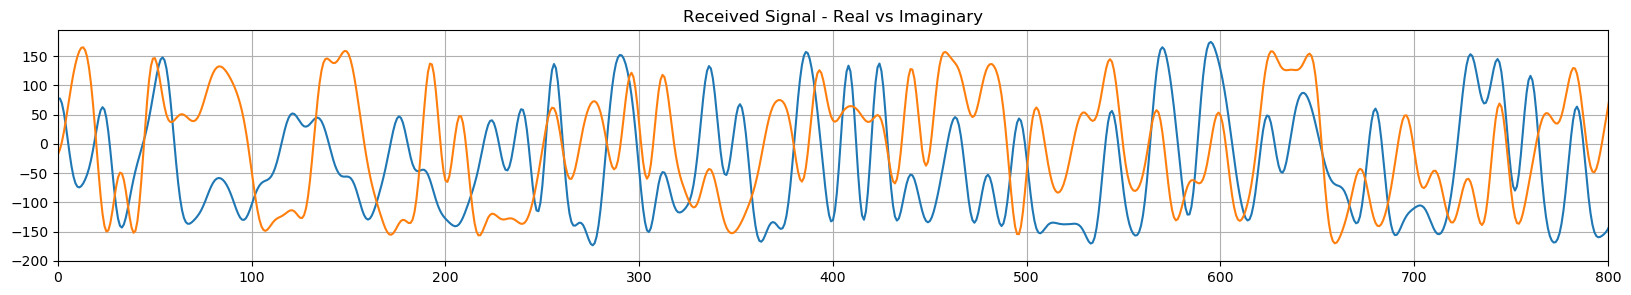

In [117]:
q_filtered_r = np.convolve(demodulated_q, filter_response)
q_filtered_r = q_filtered_r[delay:]
i_filtered_r = np.convolve(demodulated_i, filter_response)
i_filtered_r = i_filtered_r[delay:]
t = np.arange(len(i_filtered_r))

plt.figure(figsize=(20, 3))
plt.plot(t, i_filtered_r, q_filtered_r)
plt.xlim(0, 800)
plt.title("Received Signal - Real vs Imaginary")
plt.grid(True)
plt.show()

# Signal Quality 

### Eye Diagram
Se genera al superponer distintas combinaciones de unos y ceros. Se pueden observar cosas como:
- Periodo del bit: período entre la apertura y cierre del ojo. Se obtiene a partir del cruce de amplitud y el cruce de tiempo.
- Jitter: corresponde básicamente a una desviación de fase respecto de la posición ideal en el tiempo de una señal digital que se propaga en un canal de transmisión
- Cruce de amplitud: se refiere al nivel de voltaje en el cual se produce la apertura del ojo y su posterior cierre.
- Cruce de tiempo: se refiere al tiempo en el que se produce la apertura del ojo y su posterior cierre.

### Constellation
Es un método de representación en el plano complejo de los estados de símbolo en términos de amplitud y fase en los esquemas de modulación digital tales como QAM o PSK. Típicamente, el eje horizontal se refiere a los componentes de los símbolos que están en fase con la señal portadora y el eje vertical a los componentes en cuadratura (90°). Los diagramas de constelación también pueden usarse para reconocer el tipo de interferencia y distorsión en una señal. 


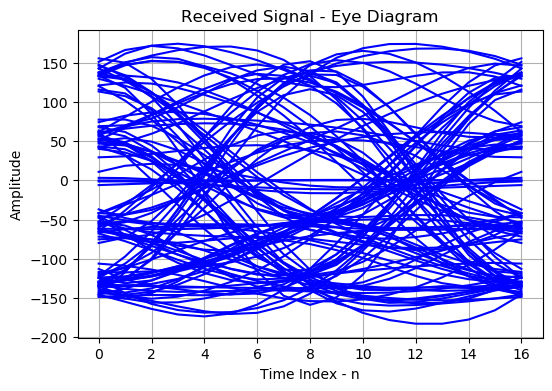

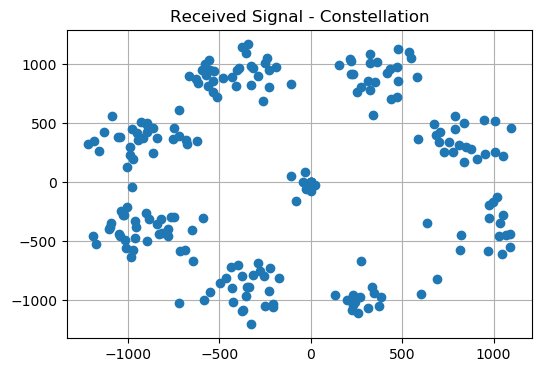

In [118]:
# --------------------- Diagrama de Ojo ---------------------#
from sk_dsp_comm import digitalcom as dc
length_eye = sps*2      # display length in samples (usually two symbols)
start = 0               # start index

dc.eye_plot(i_filtered_r, length_eye, start)
plt.title("Received Signal - Eye Diagram")
#dc.eye_plot(q_filtered_r, length_eye, start)
#plt.title("Diagrama de ojo - Señal Imaginaria")
plt.show()

# ----------------------  Constelación ---------------------#

i_sampled = np.convolve(i_filtered_r, np.ones(sps))
i_sampled = i_sampled[int(sps/2):]
i_sampled = i_sampled[sps::sps]
q_sampled = np.convolve(q_filtered_r, np.ones(sps))
q_sampled = q_sampled[int(sps/2):]
q_sampled = q_sampled[sps::sps]

plt.figure(figsize=(6, 4))
plt.plot(i_sampled, q_sampled, 'o')
plt.title("Received Signal - Constellation")
plt.grid(True)
plt.show()

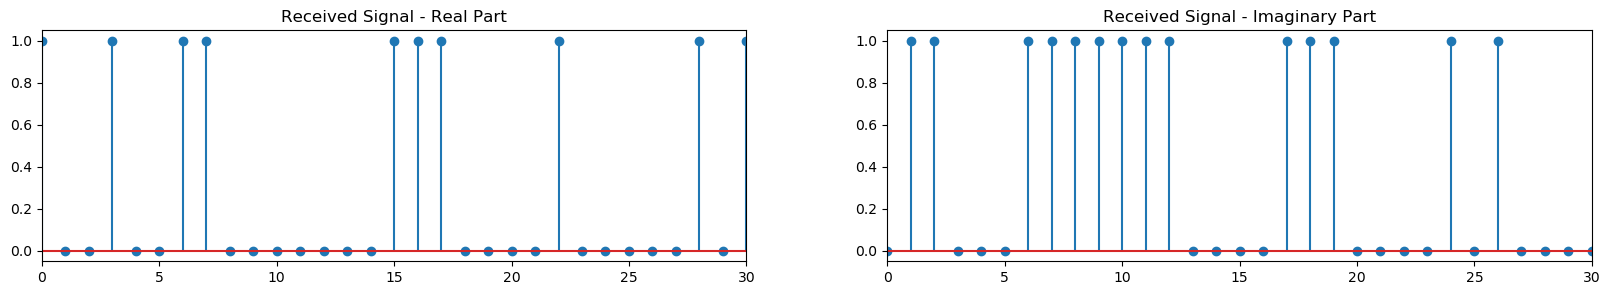

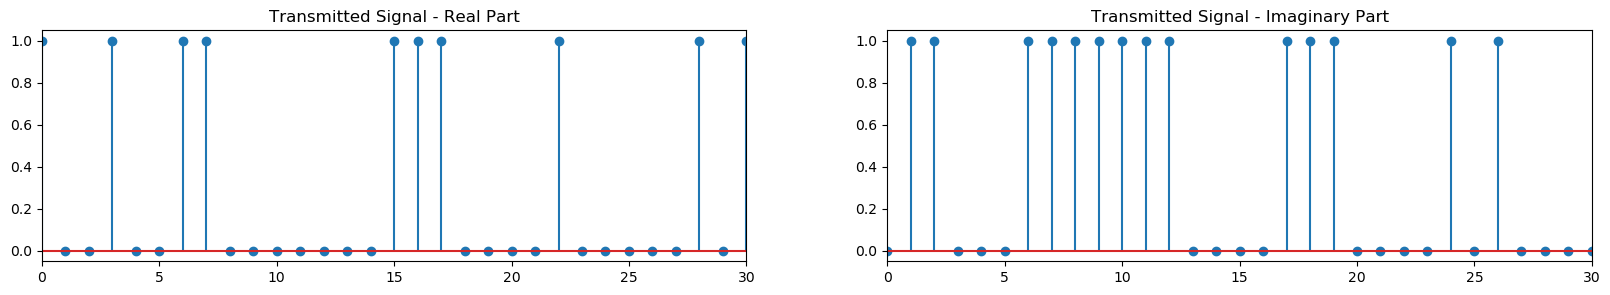

In [119]:
i_estimated = np.array([])
for bit in range(0, len(i_filtered_r), sps):  # range(start, stop, step)
    if i_filtered_r[bit] > 0.5:
        i_estimated = np.concatenate((i_estimated, [1]))
    else:
        i_estimated = np.concatenate((i_estimated, [0]))

q_estimated = np.array([])
for bit in range(0, len(q_filtered_r), sps):  # range(start, stop, step)
    if q_filtered_r[bit] > 0.5:
        q_estimated = np.concatenate((q_estimated, [1]))
    else:
        q_estimated = np.concatenate((q_estimated, [0]))

n = np.arange(len(i_estimated))
#print(q_filtered_r[0:100], q_estimated[0:100])

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.stem(i_estimated, use_line_collection=True)
plt.xlim(0, 30)
plt.title("Received Signal - Real Part")
plt.subplot(1, 2, 2)
plt.stem(q_estimated, use_line_collection=True)
plt.xlim(0, 30)
plt.title("Received Signal - Imaginary Part")
plt.show()

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.stem(i_bits, use_line_collection=True)
plt.xlim(0, 30)
plt.title("Transmitted Signal - Real Part")
plt.subplot(1, 2, 2)
plt.stem(q_bits, use_line_collection=True)
plt.xlim(0, 30)
plt.title("Transmitted Signal - Imaginary Part")
plt.show()

In [120]:
q_error = 0
i_error = 0
#print("Bits entrada: ", i_bits, "\nBits estimados: ", i_sampled)
for bit in range(0, len(i_bits)):
    if i_bits[bit] != i_estimated[bit]:
        i_error = i_error + 1

for bit in range(0, len(q_bits)):
    if q_bits[bit] != q_estimated[bit]:
        q_error = q_error + 1

BER = ((i_error + q_error) / (len(i_bits) + len(q_bits)))*100

print("Transmitted bits: ", (len(i_bits) + len(q_bits)),
      "\nError bits: ", i_error + q_error, "\nBER: {:.2f}%".format(BER))

Transmitted bits:  400 
Error bits:  0 
BER: 0.00%


### Referencias
- https://es.wikipedia.org/wiki/Diagrama_de_constelaci%C3%B3n
- https://www.edn.com/eye-diagram-basics-reading-and-applying-eye-diagrams/
- https://pysdr.org/index.html
- https://greenteapress.com/thinkdsp/html/
- https://www.gaussianwaves.com/2015/06/how-to-generate-awgn-noise-in-matlaboctave-without-using-in-built-awgn-function/
- https://www.youtube.com/watch?v=mfrWVfejMvI&list=PLvzjXN3RemgfNPxlxGEZpvkewSCrHmYGb&index=1
- https://www.ijeter.everscience.org/Manuscripts/Volume-4/Issue-8/Vol-4-issue-8-M-01.pdf
- http://atlantarf.com/attachments/File/Link_Budget_-_Digital_Modulation_Part_3.pdf 